**INTENT CLASSIFICATION**

Intent classification is a classification where a multi-class type model predict the user intent. intent classification is the process of classifying the customer's intent by analyzing the langauage they use. **I am using BERT model for intent classification**

**I have worked on a Two dataset ( one choosen by group and another which has single intent) to get the better understanding of the experiment on different dataset.**



**Dataset ( The  dataset with single intent )**

In [1]:

import os
import math
import datetime

In [2]:
from tqdm import tqdm

In [3]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

Here I am using tensorflow framework , Keras is high level interface that uses tensorflow for its backend, It runs both on CPU and GPU. Keras runs for almost all models of neaural networks. I will use bert model layer wrapper to create Keras layer

In [4]:

!pip install bert
!pip install bert-for-tf2
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

Above are the libararies which are used to retain weights and loads and add values to bert layer and tokenizer are used to convert words to token.


In [5]:
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)


seed is set to get the same result in every run.

In [44]:
classes=['tag']

**Getting the data ready**

The dataset we have is in JSON format which contains sentence and intent. We have different intents in a dataset. 

In [45]:
import json
with open ('drive/MyDrive/NLP/dataset.json') as json_file:
  CL150 = json.load(json_file)
  x=CL150['intents']

In [46]:
stage_1 = CL150['intents']

In [47]:
ar=[]
for d1 in stage_1:
    for ent in d1['patterns']:
#print(ent)
        ar.append(

    {
       'intent':d1['tag'],
#'patterns': d2['patterns']
      'sentence':ent
}
)
        

In [48]:
l1=pd.DataFrame(ar)
l1

intent           sentence
0    greeting                 Hi
1    greeting                Hey
2    greeting              Hello
3    greeting      Good morning!
4    greeting  Hey! Good morning
..        ...                ...
205   general               cool
206   general                hmm
207   general               fine
208   general             thanks
209   general               uhuh

[210 rows x 2 columns]

In [49]:
#print(x[0]['entities'])
l1



intent           sentence
0    greeting                 Hi
1    greeting                Hey
2    greeting              Hello
3    greeting      Good morning!
4    greeting  Hey! Good morning
..        ...                ...
205   general               cool
206   general                hmm
207   general               fine
208   general             thanks
209   general               uhuh

[210 rows x 2 columns]

In [51]:
pd.DataFrame(l1)

intent           sentence
0    greeting                 Hi
1    greeting                Hey
2    greeting              Hello
3    greeting      Good morning!
4    greeting  Hey! Good morning
..        ...                ...
205   general               cool
206   general                hmm
207   general               fine
208   general             thanks
209   general               uhuh

[210 rows x 2 columns]

In [52]:
len(l1)/3. #2130


70.0

In [53]:
len(l1)

210

This JSON file has all the train , test and validated data and here we are just reading the file and splitting train, test and validate.If you dont split the data we may end up getting biased results resulting into giving false impression of better model accuracy.Here we are checking if the classes in the dataset is present in the trained , test and validate data or not. If yes then we are converting the JSON data into a structured data frame below.





In [54]:
df_1 = pd.DataFrame(l1[0:209])
df_1.to_csv('train_1.csv', index=False,header=('intent','sentence'))
train_1=pd.read_csv('train_1.csv')
print(len(train_1))
train_1.head()

209


intent           sentence
0  greeting                 Hi
1  greeting                Hey
2  greeting              Hello
3  greeting      Good morning!
4  greeting  Hey! Good morning

In [55]:
df_1 = pd.DataFrame(l1[70:209])
df_1.to_csv('test_1.csv', index=False,header=('intent','sentence'))
test_1=pd.read_csv('test_1.csv')
print(len(test_1))
test_1.head()


139


intent                            sentence
0  hours           Are you open on all days?
1  hours                    are you open now
2  hours            are you open on holidays
3  hours  are you guys open on all weekdays?
4  hours                       working hours

In [56]:
df_1 = pd.DataFrame(l1[209:])
df_1.to_csv('val_1.csv', index=False,header=('intent','sentence'))
valid_1=pd.read_csv('val_1.csv')
print(len(valid_1))
valid_1.head()


1


intent sentence
0  general     uhuh

In [57]:
train_1 = train_1.append(valid_1).reset_index(drop=True)

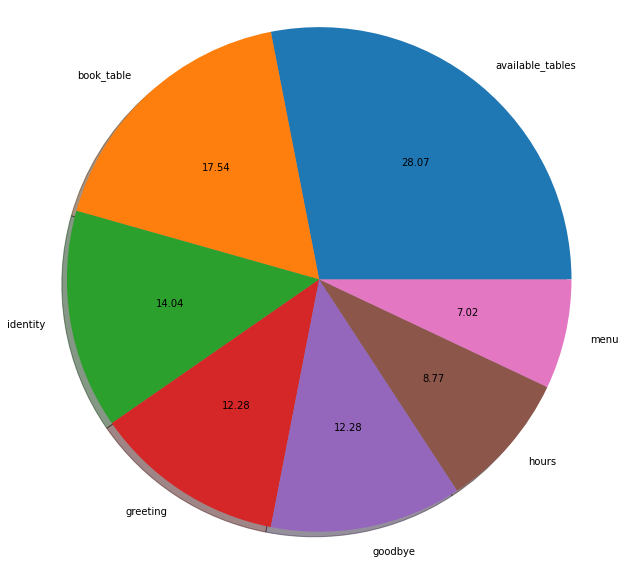

In [35]:
plt.figure(figsize=(10,10))
plt.pie(Y1,labels=X1,shadow=True,autopct='%.2f')
plt.axis('equal')
plt.show()

In [58]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2022-05-20 13:09:24--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.128, 172.217.193.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip.2’

uncased_L-12_H-768_ 100%[===================>] 388.84M   166MB/s    in 2.3s    

2022-05-20 13:09:26 (166 MB/s) - ‘uncased_L-12_H-768_A-12.zip.2’ saved [407727028/407727028]



**MODEL**

Below is our model which we are going to use , the model which uses bert's base and case model, this model have 12 layers hidden size 768 , 12 attention heads and 110 million enviornment, so bert basically has two versions , the first version has 12 encoders , which is base model and second version has 24 encoders which is large model. We are using the base model and this is a pre-trained model which we will use in our port and it has files like check point and configuration that will help in our code . 

In [59]:
os.makedirs("model2", exist_ok=True)
bert_model_name="uncased_L-12_H-768_A-12"
bert_ckpt_dir = os.path.join("model2/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [60]:
from bert import model


import zipfile
with zipfile.ZipFile('uncased_L-12_H-768_A-12.zip', 'r') as zip_ref:
    zip_ref.extractall("model2")

**Data pre-processing techniques( Tokenization and normalisation of text )**

In the below class data preparation , we pass train-test data , tokenizer , classes and max sequence slides as its input , to use a pre-trained model we need to convert the input data into a appropriate format so that each sentence can be sent into a pretend model to obtain the corresponding embedding , for this we define a function called prepare_data and in that function we are preparing the data as for the input tokenization is the process of dividing the text into pieces , such as we are dividing this words , keywords , phrases into small tokens and tokenizer dot converts token ids which is basically a function that converts the string of sentences into integers using tokenizer. To preprocess the input text we have to add our two external token that is CLS token and second is SEP , CLS will define the class of the sentence and SEP will seperate a token which is used to seperate the senetence from the next sentence , finally we got token embedding and classes as the output of this function , and the second function is data padding , in this the bert model receives a fixed length of a sentence set as its endpoint , if the sentences are shorter than the maximum length will have to padding to the sentence to make up the length 

In [61]:
class DataPreparation:
    
    text_column = "sentence"
    label_column = "intent"

    def __init__(self, train_1, test_1, tokenizer: FullTokenizer, classes, max_seq_len=192):
        self.tokenizer = tokenizer
        self.max_seq_len = 0
        self.classes = classes

        ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self.prepare_data, [train_1, test_1])

        print("max seq_len", self.max_seq_len)
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.test_x = map(self.data_padding, [self.train_x, self.test_x])

    def prepare_data(self, df):
        x, y = [], []

        for _, row in tqdm(df.iterrows()):
            text, label = row[DataPreparation.text_column], row[DataPreparation.label_column]
            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"] + tokens + ["[SEP]"]
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            self.max_seq_len = max(self.max_seq_len, len(token_ids))
            x.append(token_ids)
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)

    def data_padding(self, ids):
        x = []
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
        return np.array(x)

In [62]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "/content/model2/uncased_L-12_H-768_A-12/vocab.txt"))

**Fine Tuning**

In the model definition below we will load the model and attach couple layers on it , we are fine tuning the pre-trained bert model using input text and intent.We have also flatten the output and added dropout to the the two fully connected layers , the last layer will have a soft max activation function , the number of output will equal to the number of intent we have that is 29 and which is also the length of the classes

By the experiment I have found that fine tuning is appropriate for the dataset.

In [63]:

def model_defination1(max_seq_len, bert_ckpt_file):
    
    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")
        
    input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
    bert_output = bert(input_ids)

    print("bert shape", bert_output.shape)

    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    cls_out = keras.layers.Dropout(0.5)(cls_out)
    logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
    logits = keras.layers.Dropout(0.5)(logits)
    logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

    model2 = keras.Model(inputs=input_ids, outputs=logits)
    model2.build(input_shape=(None, max_seq_len))

    load_stock_weights(bert, bert_ckpt_file)

    return model2

Finally its time to put everything together , we start by creating a data object , we will provide model , train-test data , tokenizer , intent classes using the maximum sequence length 128

In [64]:
 
classes = train_1.intent.unique().tolist()

data_1 = DataPreparation(train_1, test_1, tokenizer, classes, max_seq_len=128)

210it [00:00, 5471.88it/s]
139it [00:00, 5375.23it/s]

max seq_len 15


In [65]:
data_1.train_x.shape


(210, 15)

In [66]:
data_1.train_x[0]

array([ 101, 7632,  102,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0])

In [31]:
data_1.train_y[0]


0

In [67]:
model2 = model_defination1(data_1.max_seq_len,bert_ckpt_file)

bert shape (None, 15, 768)
Done loading 196 BERT weights from: model2/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f735bf36a50> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [68]:
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 15)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 15, 768)           108890112 
_________________________________________________________________
lambda_1 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 768)               590592    
_________________________________________________________________
dropout_3 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 18)               

In the summary we can notice that even if it is the same model , it has almost 110 million parameteres  , fine tuning models like bert is art of doing tons of experiments 

In [34]:
!pip3 install Tensorflow==2.3 

     |████████████████████████████████| 320.4 MB 47 kB/s 
     |████████████████████████████████| 2.9 MB 8.0 MB/s 
     |████████████████████████████████| 459 kB 47.1 MB/s 
     |████████████████████████████████| 20.1 MB 41.7 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: Tensorflow
    Found existing installation: tensorflow 2.8.0+zzzcolab20220506162203
    Uninstall

In [35]:
!pip install 'h5py==2.10.0'

In [69]:
model2.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

**HYPERPARAMETER OPTIMISATION**

In this dataset there is only 1 intent thats why I have done hyperparameter optimisation in the main dataset which I have done below, there I did experiments by experimenting at which values I get the best results.

In [87]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[-3]
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model2.fit(
  x=data_1.train_x, 
  y=data_1.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=20,
  callbacks=[tensorboard_callback]
)

Epoch 1/20
12/12 [==============================] - 37s 3s/step - loss: 2.7046 - acc: 0.3439 - val_loss: 2.9500 - val_acc: 0.0000e+00
Epoch 2/20
12/12 [==============================] - 39s 3s/step - loss: 2.6496 - acc: 0.4339 - val_loss: 2.9498 - val_acc: 0.0000e+00
Epoch 3/20
12/12 [==============================] - 36s 3s/step - loss: 2.6302 - acc: 0.4444 - val_loss: 2.9549 - val_acc: 0.0000e+00
Epoch 4/20
12/12 [==============================] - 39s 3s/step - loss: 2.5895 - acc: 0.4497 - val_loss: 2.9521 - val_acc: 0.0000e+00
Epoch 5/20
12/12 [==============================] - 43s 4s/step - loss: 2.5448 - acc: 0.4974 - val_loss: 2.9500 - val_acc: 0.0000e+00
Epoch 6/20
12/12 [==============================] - 37s 3s/step - loss: 2.5108 - acc: 0.5450 - val_loss: 2.9537 - val_acc: 0.0000e+00
Epoch 7/20
12/12 [==============================] - 37s 3s/step - loss: 2.5068 - acc: 0.5450 - val_loss: 2.9541 - val_acc: 0.0000e+00
Epoch 8/20
12/12 [==============================] - 37s 3s/ste

In [88]:
_, train_acc = model2.evaluate(data_1.train_x, data_1.train_y)
_, test_acc = model2.evaluate(data_1.test_x, data_1.test_y)

5/5 [==============================] - 6s 1s/step - loss: 2.2494 - acc: 0.7482


In [89]:
print("train acc", train_acc)
print("test acc", test_acc)

train acc 0.8190476298332214
test acc 0.7482014298439026


Here, there is only one intent which is " Book Restaurant " so I got the 100 percent accuracy of both test and train data but in the later part of the assignment I have chosen a main dataset which has several intents and there accuracy is less as compared to this dataset.

In [106]:
sentences = ["hey"]
pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))
pred_token_ids = map(
  lambda tids: tids +[0]*(data_1.max_seq_len-len(tids)),
  pred_token_ids
)
pred_token_ids = np.array(list(pred_token_ids))
predictions = model2.predict(pred_token_ids).argmax(axis=-1)
for text, label in zip(sentences, predictions):
    print("text:", text, "\nintent:", classes[label])
    print()


text: hey 
intent: greeting



Here is the final output of this dataset

**DATASET (multiple intents)**

In [ ]:
import os
import math
import datetime

In [ ]:
from tqdm import tqdm

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras


Similarly , Here I am using tensorflow framework , Keras is high level interface that uses tensorflow for its backend, It runs both on CPU and GPU. Keras runs for almost all models of neaural networks. I will use bert model layer wrapper to create Keras layer

In [ ]:
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)


**Getting the data ready**

The dataset we have is in JSON format which contains sentence and multiple intent. We have different intents in a dataset. 


In [ ]:
import json
with open ('drive/MyDrive/Tk/data_ful.json') as json_file:
  CLINC150 = json.load(json_file)
  CLINC150_train=CLINC150['train']
  CLINC150_test=CLINC150['test']
  CLINC150_val=CLINC150['val']

The dataset we have is in JSON format which contains sentence and intent. We have different intents in a dataset. This file has all the train , test and validated data and here we are just reading the file and spliting train , test and validate.

In [ ]:
classes=['insurance',
 'next_holiday',
 'repeat',
 'credit_limit_change',
 'book_hotel',
 'yes',
 'damaged_card',
 'rewards_balance',
 'time',
 'pto_balance',
 'interest_rate',
 'change_volume',
 'taxes',
 'sync_device',
 'traffic',
 'what_song',
 'shopping_list',
 'todo_list_update',
 'order_checks',
 'shopping_list_update']
 

Above are the intent classes present in the data.

In [ ]:
train_data=[]
test_data=[]
val_data=[]

In [ ]:
for c in CLINC150_train:
    if c[1] in classes:
        train_data.append(c)

In [ ]:
for c in CLINC150_test:
    if c[1] in classes:
        test_data.append(c)

In [ ]:
for c in CLINC150_val:
    if c[1] in classes:
        val_data.append(c)
        

Here we are checking if the classes in the dataset is present in the trained , test and validate data or not. If yes then we are converting the JSON data into a structured data frame below and splitting them into train, test and validate.

**Training set**

It is the set of data that is used to train and make the model learn the hidden features/patterns in the data.

In each epoch, the same training data is fed to the neural network repeatedly, and the model continues to learn the features of the data.

The training set should have a diversified set of inputs so that the model is trained in all scenarios and can predict any unseen data sample that may appear in the future.


In [ ]:
df = pd.DataFrame(train_data)
df.to_csv('train_data.csv3', index=False,header=('text','intent'))
train=pd.read_csv('train_data.csv3')
print(len(train))
train.head()

2000


text intent
0  what time is it in punta gorda, florida   time
1  what time is it in glenwood springs, co   time
2    what time is it in fredericksburg, tx   time
3         what time is it in las vegas, nv   time
4           what time is it in houston, tx   time

**Validation set**

The validation set is a set of data, separate from the training set, that is used to validate our model performance during training.

This validation process gives information that helps us tune the model’s hyperparameters and configurations accordingly. It is like a critic telling us whether the training is moving in the right direction or not.


In [ ]:
df = pd.DataFrame(val_data)
df.to_csv('val_data.csv', index=False,header=('text','intent'))
valid=pd.read_csv('val_data.csv')
print(len(valid))
valid.head()

400


text intent
0            what time is it in france   time
1  what's the time in london right now   time
2            what hour is it in london   time
3                      what's the time   time
4           what is the time in london   time


**Test set**

The test set is a separate set of data used to test the model after completing the training.

It provides an unbiased final model performance metric in terms of accuracy, precision, etc. To put it simply, it answers the question of "How well does the model perform?"

In [ ]:
df = pd.DataFrame(test_data)
df.to_csv('test_data.csv', index=False,header=('text','intent'))
test=pd.read_csv('test_data.csv')
print(len(test))
test.head()

600


text intent
0  i need you to tell me what time it is in new y...   time
1   what time is it in adelaide, australia right now   time
2                                   is it after noon   time
3                              is it six o clock yet   time
4  please give me the time in tanzania at this mo...   time

In [ ]:
train = train.append(valid).reset_index(drop=True)

In [ ]:
train

text        intent
0               what time is it in punta gorda, florida          time
1               what time is it in glenwood springs, co          time
2                 what time is it in fredericksburg, tx          time
3                      what time is it in las vegas, nv          time
4                        what time is it in houston, tx          time
...                                                 ...           ...
2395                     please send me more checkbooks  order_checks
2396      please notify my bank that i need more checks  order_checks
2397      how can i order checks for my savings account  order_checks
2398  i need to know how to order checks for my bank...  order_checks
2399  who do i contact to order more checks for my t...  order_checks

[2400 rows x 2 columns]

**Data Visualisation**

In [ ]:
from matplotlib import pyplot as plt

X=list(train['intent'].value_counts().keys())
Y=list(train['intent'].value_counts())

In [ ]:
X

['time',
 'shopping_list_update',
 'traffic',
 'shopping_list',
 'credit_limit_change',
 'interest_rate',
 'pto_balance',
 'taxes',
 'book_hotel',
 'what_song',
 'change_volume',
 'next_holiday',
 'damaged_card',
 'sync_device',
 'todo_list_update',
 'insurance',
 'yes',
 'repeat',
 'rewards_balance',
 'order_checks']

In [ ]:
Y

[120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120,
 120]

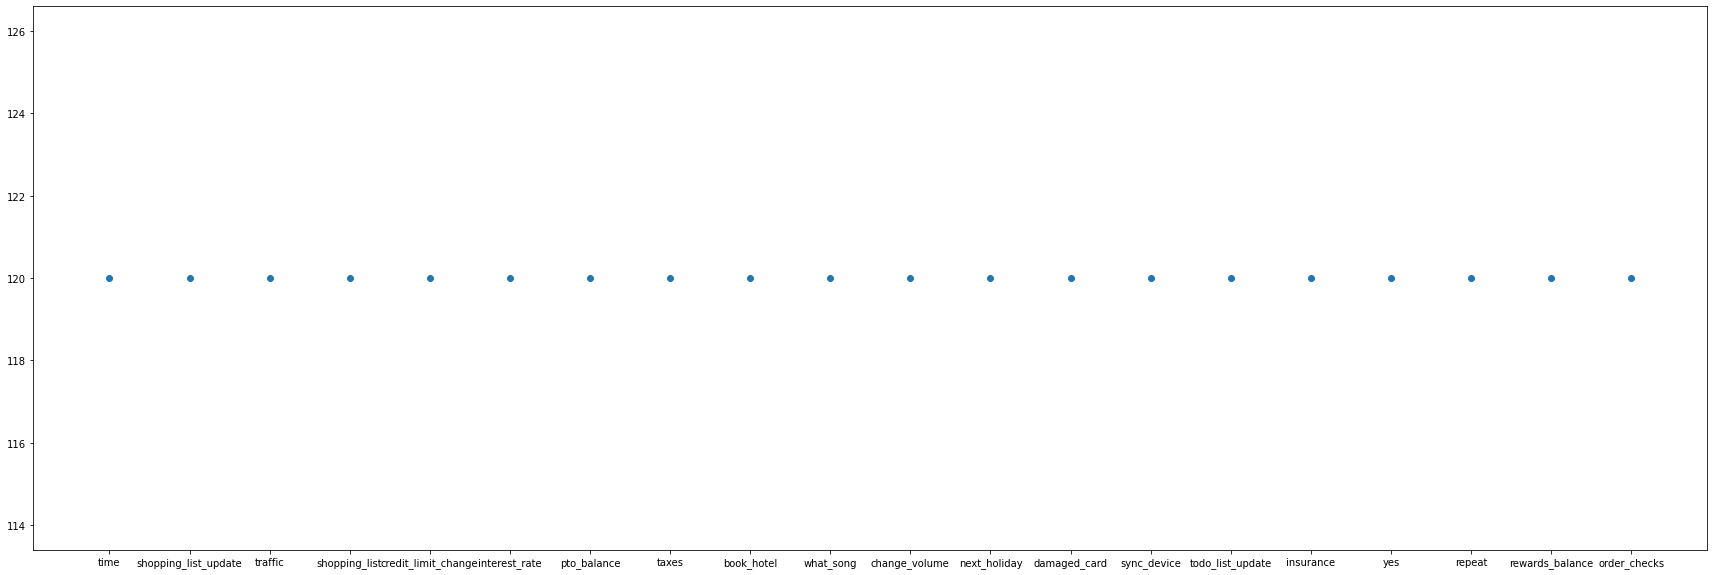

In [ ]:
plt.figure(figsize=(30,10))
plt.scatter(X,Y)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.pie(Y,labels=X,shadow=True,autopct='%.2f')
plt.axis('equal')
plt.show()

Here we can see that there are different intent classes which are equally divided .

In [ ]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2022-05-03 21:21:09--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 142.250.145.128, 173.194.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip.2’

uncased_L-12_H-768_ 100%[===================>] 388.84M   110MB/s    in 3.7s    

2022-05-03 21:21:13 (105 MB/s) - ‘uncased_L-12_H-768_A-12.zip.2’ saved [407727028/407727028]



**BERT MODEL**

Below is our model which we are going to use , the model which uses bert's base and case model, this model have 12 layers hidden size 768 , 12 attention heads and 110 million enviornment, so bert basically has two versions , the first version has 12 encoders , which is base model and second version has 24 encoders which is large model. We are using the base model and this is a pre-trained model which we will use in our port and it has files like check point and configuration that will help in our code . 

In [ ]:
os.makedirs("model2", exist_ok=True)
bert_model_name="uncased_L-12_H-768_A-12"
bert_ckpt_dir = os.path.join("model2/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [ ]:
from bert import model


import zipfile
with zipfile.ZipFile('uncased_L-12_H-768_A-12.zip', 'r') as zip_ref:
    zip_ref.extractall("model2")

**Data pre-processing techniques( Tokenization and normalisation of text )**

In the below class data preparation , we pass train-test data , tokenizer , classes and max sequence slides as its input , to use a pre-trained model we need to convert the input data into a appropriate format so that each sentence can be sent into a pretend model to obtain the corresponding embedding , for this we define a function called prepare_data and in that function we are preparing the data as for the input tokenization is the process of dividing the text into pieces , such as we are dividing this words , keywords , phrases into small tokens and tokenizer dot converts token ids which is basically a function that converts the string of sentences into integers using tokenizer. To preprocess the input text we have to add our two external token that is CLS token and second is SEP , CLS will define the class of the sentence and SEP will seperate a token which is used to seperate the senetence from the next sentence , finally we got token embedding and classes as the output of this function , and the second function is data padding , in this the bert model receives a fixed length of a sentence set as its endpoint , if the sentences are shorter than the maximum length will have to padding to the sentence to make up the length 

In [ ]:
class DataPreparation:
    
    text_column = "text"
    label_column = "intent"

    def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
        self.tokenizer = tokenizer
        self.max_seq_len = 0
        self.classes = classes

        ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self.prepare_data, [train, test])

        print("max seq_len", self.max_seq_len)
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.test_x = map(self.data_padding, [self.train_x, self.test_x])

    def prepare_data(self, df):
        x, y = [], []

        for _, row in tqdm(df.iterrows()):
            text, label = row[DataPreparation.text_column], row[DataPreparation.label_column]
            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"] + tokens + ["[SEP]"]
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            self.max_seq_len = max(self.max_seq_len, len(token_ids))
            x.append(token_ids)
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)

    def data_padding(self, ids):
        x = []
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
        return np.array(x)

In [ ]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "/content/model2/uncased_L-12_H-768_A-12/vocab.txt"))

**Fine Tuning**

In the model definition below we will load the model and attach couple layers on it , we are fine tuning the pre-trained bert model using input text and intent.We have also flatten the output and added dropout to the the two fully connected layers , the last layer will have a soft max activation function , the number of output will equal to the number of intent we have that is 29 and which is also the length of the classes

By the experiment I have found that fine tuning is appropriate for the dataset.

In [ ]:

def model_defination(max_seq_len, bert_ckpt_file):
    
    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")
        
    input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
    bert_output = bert(input_ids)

    print("bert shape", bert_output.shape)

    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    cls_out = keras.layers.Dropout(0.5)(cls_out)
    logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
    logits = keras.layers.Dropout(0.5)(logits)
    logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

    model2 = keras.Model(inputs=input_ids, outputs=logits)
    model2.build(input_shape=(None, max_seq_len))

    load_stock_weights(bert, bert_ckpt_file)

    return model2

Finally its time to put everything together , we start by creating a data object , we will provide model , train-test data , tokenizer , intent classes using the maximum sequence length 128

In [ ]:

classes = train.intent.unique().tolist()

data = DataPreparation(train, test, tokenizer, classes, max_seq_len=128)

2400it [00:00, 2458.16it/s]
600it [00:00, 2671.63it/s]

max seq_len 29


In [ ]:
data.train_x.shape

(2400, 29)

In [ ]:
data.train_x[0]

array([  101,  2054,  2051,  2003,  2009,  1999, 27377,  2175, 13639,
        1010,  3516,   102,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0])

In [ ]:
data.train_y[0]

0

In [ ]:
model2 = model_defination(data.max_seq_len,bert_ckpt_file)

bert shape (None, 29, 768)
Done loading 196 BERT weights from: model2/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fcaf33c4750> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [ ]:
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 29)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 29, 768)           108890112 
_________________________________________________________________
lambda_1 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 768)               590592    
_________________________________________________________________
dropout_3 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)               

In the summary we can notice that even if it is the same model , it has almost 110 million parameteres  , fine tuning models like bert is art of doing tons of experiments 

In [ ]:
model2.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

**HYPERPARAMETER OPTIMISATION**

The choice of hyperparameters often has a strong impact on the performance of a model. Even if you use the same model, performance can drastically change depending on the hyperparameters (e.g. epchos,Batch size etc.) you use. 
In this dataset I have got worst accuracy (13 percent) at epchos 1 and batch size = 5 , In the second experiment the accuracy increased when I increased epchos to 3 and batch size to 16  got the accuracy 88 percent as shown below and when I increased the epchos to 5 and batch size to 16 and adams to 10 to the power -5  I got the best result with the accuracy of 98 percent . In the below experiment I have set it to 3 epchos because it is taking 2-3 hours to run each epchos but I am getting best result at 5 epchos.

In [ ]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[-3]
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model2.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=3,
  callbacks=[tensorboard_callback]
)

Epoch 1/3
135/135 [==============================] - 537s 4s/step - loss: 2.9513 - acc: 0.1389 - val_loss: 2.8319 - val_acc: 0.4042
Epoch 2/3
135/135 [==============================] - 528s 4s/step - loss: 2.5927 - acc: 0.6042 - val_loss: 2.2377 - val_acc: 0.8542
Epoch 3/3
135/135 [==============================] - 532s 4s/step - loss: 2.2474 - acc: 0.8856 - val_loss: 2.2080 - val_acc: 0.8667


In [ ]:
list(history.history['acc'])

[0.1388888955116272, 0.6041666865348816, 0.8856481313705444]

Here we can see the result of accuracy after execution of each epchos. The worst result is at one and best is at 3 with batch size=16

In [ ]:


import matplotlib.pyplot as plt


plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.ylabel('accuracy')
plt.xlabel('loss')
plt.legend(['train'],loc='upper left')
plt.show()

In this graph we can see that accuracy is increasing and loss is decreasing.

In [ ]:
_, train_acc1 = model2.evaluate(data.train_x, data.train_y)
_, test_acc1 = model2.evaluate(data.test_x, data.test_y)

19/19 [==============================] - 41s 2s/step - loss: 2.1792 - acc: 0.8967


**Accuracy**

In [ ]:
print("train acc", train_acc1)
print("test acc", test_acc1)

train acc 0.9358333349227905
test acc 0.8966666460037231


In [ ]:
a1=['Train_dataset_accuracy','test_dataset_accuracy']
b1=[train_acc1,test_acc1]

In [ ]:
plt.bar(a1,b1)
plt.xlabel('Train and Test Accuracy')
plt.ylabel('Accuracy')
plt.show()

Here, we can see the train dataset accuracy (0.93) is more than test dataset accuracy (0.89)

In [ ]:
plt.plot(a1,b1,'b--')
plt.xlabel('Train and Test Accuracy')
plt.ylabel('Accuracy')
plt.show()

Finally, below we can see Model can predict the intent by seeing the sentence .

In [ ]:
sentences = [
  "is it six o clock yet",
  "find me a hotel with good reviews in phoenix"
]
pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))
pred_token_ids = map(
  lambda tids: tids +[0]*(data.max_seq_len-len(tids)),
  pred_token_ids
)
pred_token_ids = np.array(list(pred_token_ids))
predictions = model2.predict(pred_token_ids).argmax(axis=-1)
for text, label in zip(sentences, predictions):
    print("text:", text, "\nintent:", classes[label])
    print()

text: is it six o clock yet 
intent: time

text: find me a hotel with good reviews in phoenix 
intent: book_hotel



**Conclusion**

By seeing the model which can predict the intent by seeing the sentence, we can conclude that chatbot components I experimented fulfil their purpose. 

While doing the experimentation I found that In the dataset I have got worst accuracy (13 percent) at epchos 1 and batch size = 5 , In the second experiment the accuracy increased when I increased epchos to 3 and batch size to 16 their I got the accuracy 88 percent  and **when I increased the epchos to 5 and batch size to 16 and adams to 10 to the power -5  I got the best result** with the accuracy of 98 percent . 

While experimenting I found that 88 percent accuracy is enough for the model, which is giving good results. 

when the model was not doing well I found that batch size should be increased from 5 to 16 . at batch size 5 it was performing worst with very less accuracy another factor which came into play was adams where it was not giving good results until it was set to 10 to the power -5

In the experiment I also found that if you dont split the data we may end up getting biased results resulting into giving false impression of better model accuracy.





**Choosen Dataset**

1. https://www.kaggle.com/datasets/swapnilpote/restaurant-chatbot-dataset-intent-entity

2. https://raw.githubusercontent.com/aishgrt/AI-Guild/main/Intent%20Classification%20using%20BERT/data_full.json


**References **

https://www.v7labs.com/blog/train-validation-test-set

https://guide.allennlp.org/hyperparameter-optimization#1

https://github.com/aishgrt/AI-Guild/tree/main/Intent%20Classification%20using%20BERT

https://www.analyticsvidhya.com/blog/2021/12/intent-classification-with-convolutional-neural-networks/
